In [4]:
import os
print(os.getcwd())

import os
print(os.path.exists('dataset/train_images_224.npy'))

/Users/amelia/Data_Science/DS301/Week7/midterm project/coffee-leaf-deseases-prediction-ml
True


train images: (1264, 224, 224, 3)
train labels: (1264, 4)
test images: (400, 224, 224, 3)
test labels: (400, 4)


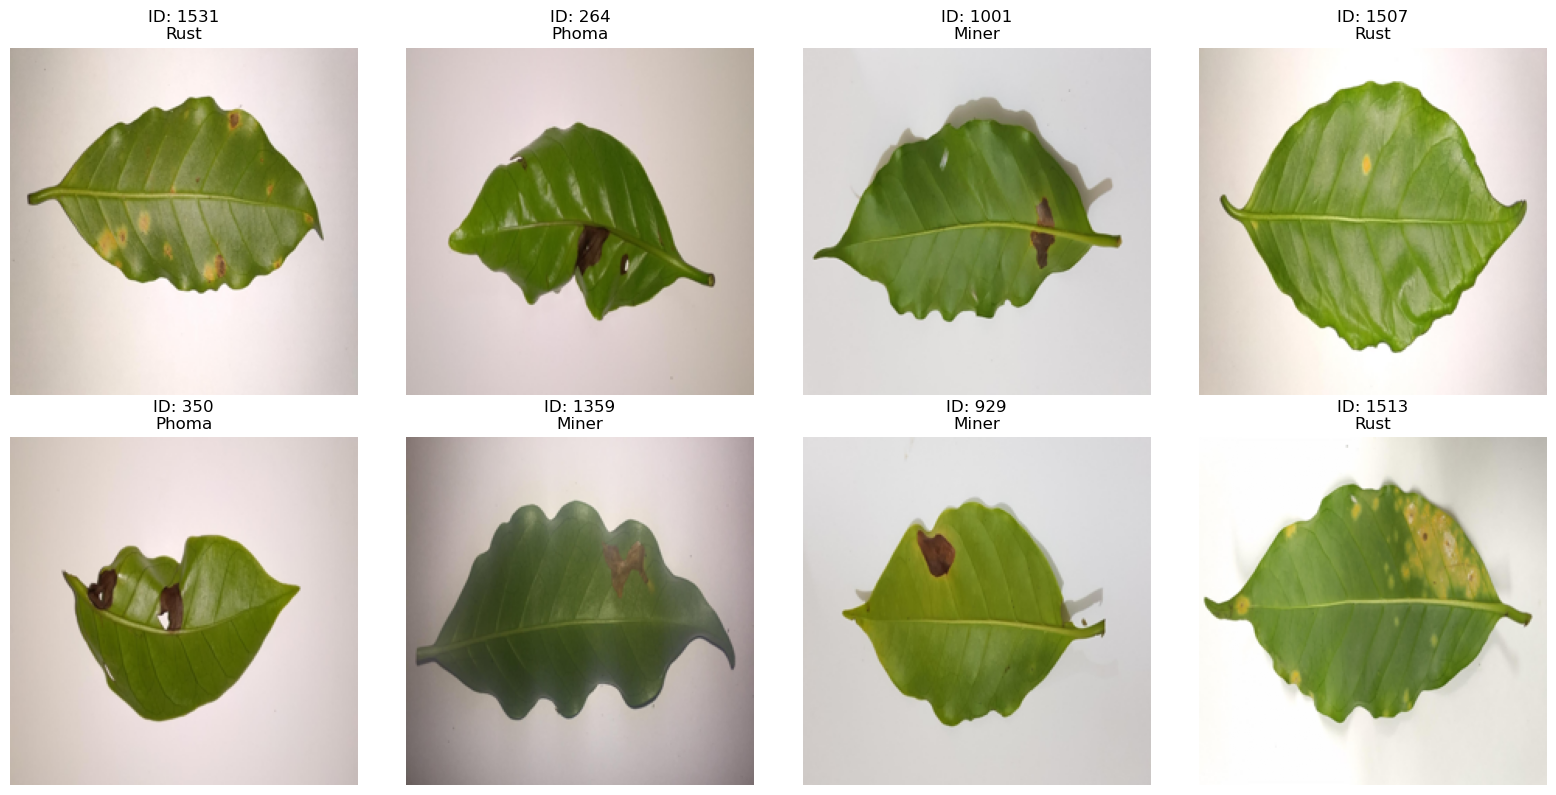

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

loaded_train_images = np.load('dataset/train_images_224.npy', allow_pickle=True)
loaded_train_labels = pd.read_csv('dataset/train_labels_224.csv')
loaded_test_images = np.load('dataset/test_images_224.npy', allow_pickle=True)
loaded_test_labels = pd.read_csv('dataset/test_labels_224.csv')

print(f"train images: {loaded_train_images.shape}")
print(f"train labels: {loaded_train_labels.shape}")
print(f"test images: {loaded_test_images.shape}")
print(f"test labels: {loaded_test_labels.shape}")


def get_diseese_name(row):
    if row['miner'] == 1:
        diseases.append('Miner')
    if row['rust'] == 1:
        diseases.append('Rust')
    if row['phoma'] == 1:
        diseases.append('Phoma')
    if not diseases:
        diseases.append('Healthy')

# sample images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
np.random.seed(43)
random_indices = np.random.choice(len(loaded_train_images), size=8, replace=False)
for i in range(8):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(loaded_train_images[random_indices[i]])
    label_info = loaded_train_labels.iloc[random_indices[i]]
    diseases = []
    if label_info['miner'] == 1:
        diseases.append('Miner')
    if label_info['rust'] == 1:
        diseases.append('Rust')
    if label_info['phoma'] == 1:
        diseases.append('Phoma')
    if not diseases:
        diseases.append('Healthy')
    axes[row, col].set_title(f"ID: {label_info['id']}\n{', '.join(diseases)}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def extract_color_features(image):
    rgb = image / 255.0 # normalize
    R, G, B = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    C, M, Y = 1 - R, 1 - G, 1 - B
    features = [
        np.mean(R), np.std(R),
        np.mean(G), np.std(G),
        np.mean(B), np.std(B),
        np.mean(C), np.std(C),
        np.mean(M), np.std(M),
        np.mean(Y), np.std(Y),
    ]
    return np.array(features)

X_train_features = np.array([extract_color_features(img) for img in loaded_train_images])
X_test_features = np.array([extract_color_features(img) for img in loaded_test_images])

y_train_multi = loaded_train_labels[['miner', 'rust', 'phoma']]
y_test_multi = loaded_test_labels[['miner', 'rust', 'phoma']]

labels = y_test_multi.columns if hasattr(y_test_multi, 'columns') else [f'label_{i}' for i in range(y_test_multi.shape[1])]

(1264, 12)


In [ ]:
# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=123,
    splitter='best'
)
multi_dt = MultiOutputClassifier(dt)
multi_dt.fit(X_train_features, y_train_multi)
y_pred_dt = multi_dt.predict(X_test_features)

# Evaluate the model
print("\n=== Evaluation Decision Tree Metrics per label ===")
for i, label in enumerate(labels):
    y_true = y_test_multi[label] if hasattr(y_test_multi, 'columns') else y_test_multi[:, i]
    y_pred = y_pred_dt[:, i]
    
    acc_dt = accuracy_score(y_true, y_pred)
    prec_dt = precision_score(y_true, y_pred, zero_division=0)
    rec_dt = recall_score(y_true, y_pred, zero_division=0)
    f1_dt = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"{label}: Accuracy={acc_dt:.4f}, Precision={prec_dt:.4f}, Recall={rec_dt:.4f}, F1-score={f1_dt:.4f}")

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test_multi, y_pred_dt))
print("Precision (micro):", precision_score(y_test_multi, y_pred_dt, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test_multi, y_pred_dt, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test_multi, y_pred_dt, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test_multi, y_pred_dt, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test_multi, y_pred_dt, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test_multi, y_pred_dt, average='macro', zero_division=0))

# ---------- KNN ----------
knn = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    n_jobs=-1,
    n_neighbors=5,
    p=2,
    weights='uniform'
)
multi_knn = MultiOutputClassifier(knn)
multi_knn.fit(X_train_features, y_train_multi)
y_pred_knn = multi_knn.predict(X_test_features)

# Evaluate the model
print("\n=== Evaluation KNN Metrics per label ===")
for i, label in enumerate(labels):
    y_true = y_test_multi[label] if hasattr(y_test_multi, 'columns') else y_test_multi[:, i]
    y_pred = y_pred_knn[:, i]
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"{label}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-score={f1:.4f}")

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test_multi, y_pred_knn))
print("Precision (micro):", precision_score(y_test_multi, y_pred_knn, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test_multi, y_pred_knn, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test_multi, y_pred_knn, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test_multi, y_pred_knn, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test_multi, y_pred_knn, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test_multi, y_pred_knn, average='macro', zero_division=0))


=== Evaluation Decision Tree Metrics per label ===
miner: Accuracy=0.7200, Precision=0.5667, Recall=0.5312, F1-score=0.5484
rust: Accuracy=0.7700, Precision=0.4074, Recall=0.6111, F1-score=0.4889
phoma: Accuracy=0.8900, Precision=0.7097, Recall=0.9167, F1-score=0.8000

=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 0.49
Precision (micro): 0.5681818181818182
Recall (micro): 0.6756756756756757
F1-score (micro): 0.6172839506172839
Precision (macro): 0.5612504978096376
Recall (macro): 0.6863425925925926
F1-score (macro): 0.6124253285543608

=== Evaluation KNN Metrics per label ===
miner: Accuracy=0.7600, Precision=0.6667, Recall=0.5000, F1-score=0.5714
rust: Accuracy=0.8200, Precision=0.5000, Recall=0.6111, F1-score=0.5500
phoma: Accuracy=0.9200, Precision=0.7500, Recall=1.0000, F1-score=0.8571

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.58
Precision (micro): 0.6538461538461539
Recall (micro): 0.6891891891891891
F1-score (micro): 0.6710526315789473
Precis

In [ ]:
# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(max_features=None, random_state=123, splitter='best')
multi_dt = MultiOutputClassifier(dt)
param_grid_dt = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': range(1, 21),
    'estimator__min_samples_split': range(2, 11),
    'estimator__min_samples_leaf': range(1, 6)
}
grid_search_dt = GridSearchCV(multi_dt, param_grid_dt, cv=5)
grid_search_dt.fit(X_train_features, y_train_multi)

print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)

# ---------- KNN ----------
knn = KNeighborsClassifier(algorithm='auto', n_jobs=-1)
multi_knn = MultiOutputClassifier(knn)
param_grid_knn = {
    'estimator__leaf_size': range(25, 36),
    'estimator__metric': ['euclidean', 'manhattan'],
    'estimator__n_neighbors': range(1, 21),
    'estimator__p': [1, 2],
    'estimator__weights': ['uniform', 'distance'],
}
grid_search_knn = GridSearchCV(multi_knn, param_grid_knn, cv=5)
grid_search_knn.fit(X_train_features, y_train_multi)

print(grid_search_knn.best_params_)
print(grid_search_knn.best_score_)

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'estimator__criterion': 'entropy', 'estimator__max_depth': 7, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2}
0.36944601292427376
{'estimator__leaf_size': 25, 'estimator__metric': 'euclidean', 'estimator__n_neighbors': 8, 'estimator__p': 1, 'estimator__weights': 'uniform'}
0.411267959094046


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
